In [ ]:
pip install lightgbm

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold

print("Start loading data...")
train_path = "train_data.csv"
test_path  = "test_data.csv"
TARGET = "reservation_status"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

if 'Unnamed: 0' in train_df.columns:
    train_df = train_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop(columns=['Unnamed: 0'])

if "row_id" in test_df.columns:
    test_row_ids = test_df["row_id"]
else:
    test_row_ids = np.arange(1, len(test_df) + 1)

if 'row_id' in train_df.columns: train_df = train_df.drop(columns=['row_id'])
if 'row_id' in test_df.columns: test_df = test_df.drop(columns=['row_id'])



le = LabelEncoder()
y_train_full = le.fit_transform(train_df[TARGET])
print("Label mapping:", {cls: int(lbl) for cls, lbl in zip(le.classes_, le.transform(le.classes_))})


print("Start advanced feature engineering...")
MONTH_MAP = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

def create_advanced_features(df):
    """
    Receives the original DataFrame and returns a new DataFrame containing all engineered features.
    """
    df_new = df.copy()


    df_new['arrival_date_month_num'] = df_new['arrival_date_month'].map(MONTH_MAP)
    df_new['month_sin'] = np.sin(2 * np.pi * df_new['arrival_date_month_num'] / 12)
    df_new['month_cos'] = np.cos(2 * np.pi * df_new['arrival_date_month_num'] / 12)
    df_new['week_sin'] = np.sin(2 * np.pi * df_new['arrival_date_week_number'] / 53)
    df_new['week_cos'] = np.cos(2 * np.pi * df_new['arrival_date_week_number'] / 53)
    df_new['day_sin'] = np.sin(2 * np.pi * df_new['arrival_date_day_of_month'] / 31)
    df_new['day_cos'] = np.cos(2 * np.pi * df_new['arrival_date_day_of_month'] / 31)

  
    try:
        # Construct recognizable date string (e.g., "2015-07-01")
        month_str = df_new['arrival_date_month_num'].astype(str).str.zfill(2)
        day_str = df_new['arrival_date_day_of_month'].astype(str).str.zfill(2)
        date_str = df_new['arrival_date_year'].astype(str) + '-' + month_str + '-' + day_str

        # Convert to datetime (invalid dates become NaT with errors='coerce')
        df_new['arrival_date_full'] = pd.to_datetime(date_str, errors='coerce')

        # Extract dayofweek (Mon=0,...,Sun=6)
        df_new['arrival_dayofweek'] = df_new['arrival_date_full'].dt.dayofweek

        # Weekend indicator (Sat=5, Sun=6)
        df_new['is_weekend_arrival'] = df_new['arrival_dayofweek'].isin([5, 6]).astype(int)

        # Cyclic weekday encoding
        df_new['dayofweek_sin'] = np.sin(2 * np.pi * df_new['arrival_dayofweek'] / 7)
        df_new['dayofweek_cos'] = np.cos(2 * np.pi * df_new['arrival_dayofweek'] / 7)

    except Exception as e:
        print(f"Error while generating DayOfWeek features: {e}")
        df_new['arrival_dayofweek'] = -1
        df_new['is_weekend_arrival'] = 0
        df_new['dayofweek_sin'] = 0
        df_new['dayofweek_cos'] = 0


    
    df_new['total_stay_nights'] = df_new['stays_in_weekend_nights'] + df_new['stays_in_week_nights']
    df_new['total_guests'] = df_new['adults'] + df_new['children'] + df_new['babies']
    
    df_new['has_children_or_babies'] = ((df_new['children'] > 0) | (df_new['babies'] > 0)).astype(int)

    df_new['weekend_ratio'] = df_new['stays_in_weekend_nights'] / (df_new['total_stay_nights'] + 1e-6)

    df_new['total_nights'] = df_new['stays_in_weekend_nights'] + df_new['stays_in_week_nights']
    df_new['total_guests'] = df_new['adults'] + df_new['children'] + df_new['babies']
    adr_median = df_new[df_new['adr'] > 0]['adr'].median()
    if pd.isna(adr_median) or adr_median == 0: adr_median = 0.01
    df_new['adr'] = df_new['adr'].replace(0, adr_median)

    df_new['is_family'] = ((df_new['children'] > 0) | (df_new['babies'] > 0)).astype(int)
    df_new['lead_vs_stay_ratio'] = df_new['lead_time'] / (df_new['total_nights'] + 1e-6)
    
    
    df_new['adr_per_person'] = df_new['adr'] / (df_new['total_guests'] + 1e-6)

    df_new['adr_per_night'] = df_new['adr'] / (df_new['total_stay_nights'] + 1e-6)

    df_new['adr_log1p'] = np.log1p(df_new['adr'].clip(lower=0))

    
    df_new['room_type_changed'] = (df_new['reserved_room_type'] != df_new['assigned_room_type']).astype(int)

    total_previous_bookings = df_new['previous_cancellations'] + df_new['previous_bookings_not_canceled']
    df_new['cancellation_rate'] = np.where(
        total_previous_bookings == 0, 0,
        df_new['previous_cancellations'] / (total_previous_bookings + 1e-6)
    )

    df_new['lead_time_vs_stay'] = df_new['lead_time'] / (df_new['total_stay_nights'] + 1e-6)

    df_new['lead_time_log1p'] = np.log1p(df_new['lead_time'])


    df_new['lead_time_bucket'] = pd.cut(
        df_new['lead_time'],
        bins=[-1, 0, 7, 30, 90, 180, 365, 1000],
        labels=['0_days', '1-7_days', '8-30_days', '31-90_days', '91-180_days', '181-365_days', '365+_days'],
        right=True
    ).astype(str)

    df_new['deposit_cust_interaction'] = df_new['deposit_type'].astype(str) + '_' + df_new['customer_type'].astype(str)
    df_new['deposit_changes_interaction'] = df_new['deposit_type'].astype(str) + '_changes_' + (df_new['booking_changes'] > 0).astype(str)
    df_new['segment_channel_interaction'] = df_new['market_segment'].astype(str) + '_' + df_new['distribution_channel'].astype(str)

    df_new['adr_is_zero'] = (df_new['adr'] == 0).astype(int)
    df_new['total_guests_is_zero'] = (df_new['total_guests'] == 0).astype(int)
    df_new['stay_is_zero'] = (df_new['total_stay_nights'] == 0).astype(int)

    df_new = df_new.drop(columns=['arrival_date_month', 'arrival_date_full'], errors='ignore')

    return df_new

X_train_fe = create_advanced_features(train_df.drop(columns=[TARGET]))
X_test_fe  = create_advanced_features(test_df)

print("Cleaning column names...")
def _safe_names(cols):
    cleaned = [re.sub(r'[^A-Za-z0-9_]+', '_', str(c)) for c in cols]
    seen = {}
    uniq = []
    for c in cleaned:
        if c not in seen:
            seen[c] = 0
            uniq.append(c)
        else:
            seen[c] += 1
            uniq.append(f"{c}__{seen[c]}")
    return uniq

safe_cols = _safe_names(X_train_fe.columns)
X_train_fe.columns = safe_cols
X_test_fe.columns  = safe_cols
assert list(X_train_fe.columns) == list(X_test_fe.columns)

print("Performing robust categorical encoding...")
tmp = pd.concat([X_train_fe, X_test_fe], axis=0, ignore_index=True)

cat_cols = tmp.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Encoding {len(cat_cols)} categorical features using .cat.codes: {cat_cols}")

for c in cat_cols:
    tmp[c] = pd.Categorical(tmp[c])
    tmp[c] = tmp[c].cat.codes.astype("int32")

X_train_final = tmp.iloc[:len(X_train_fe), :].reset_index(drop=True)
X_test_final  = tmp.iloc[len(X_train_fe):, :].reset_index(drop=True)
print(f"Final train shape: {X_train_final.shape}, test shape: {X_test_final.shape}")

cnt = Counter(y_train_full)
total = sum(cnt.values())
class_weight = {k: total / v for k, v in cnt.items()}
print("Class weights:", class_weight)


print("Start Stratified K-Fold training...")
N_SPLITS = 10
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros((len(X_train_final), len(le.classes_)))
test_preds = np.zeros((len(X_test_final), len(le.classes_)))


开始加载数据...
Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2}
开始执行高级特征工程...
开始清理列名...
开始执行健壮的类别编码...
将对 13 个特征进行 .cat.codes 编码: ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'lead_time_bucket', 'deposit_cust_interaction', 'deposit_changes_interaction', 'segment_channel_interaction']
最终训练集形状: (68898, 58), 测试集形状: (50000, 58)
Class weights: {np.int64(2): 100.7280701754386, np.int64(1): 2.7726669081250757, np.int64(0): 1.5887928052576963}
开始 5 折交叉验证训练...


In [ ]:
models = []
fold_histories = []

print("Start 10-fold cross-validation training...")

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_final, y_train_full), 1):
    print(f"\n===== Fold {fold}/{N_SPLITS} =====")
    X_tr, X_val = X_train_final.iloc[tr_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_full[tr_idx], y_train_full[val_idx]

    model = lgb.LGBMClassifier(
        objective="multiclass",
        device="gpu",
        num_class=len(le.classes_),
        n_estimators=20000,
        learning_rate=0.02,
        max_depth=15,
        num_leaves=128,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight=class_weight,
        random_state=42 + fold,
        n_jobs=-1
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_names=["valid"],
        eval_metric="multi_logloss", 
        callbacks=[
            lgb.early_stopping(stopping_rounds=500),
            lgb.log_evaluation(period=500)
        ],
        categorical_feature=cat_cols
    )

    models.append(model)

    # Capture training history for this fold
    fold_histories.append(model.evals_result_)
    

    val_prob = model.predict_proba(X_val)
    oof_preds[val_idx] = val_prob

    test_prob_fold = model.predict_proba(X_test_final)
    test_preds += test_prob_fold / N_SPLITS

print("\nK-Fold training completed")
print(f"Captured training history for {len(fold_histories)} folds.")


开始 10 折交叉验证训练...

===== Fold 1/10 =====
Training until validation scores don't improve for 500 rounds
[500]	valid's multi_logloss: 0.299216
Early stopping, best iteration is:
[476]	valid's multi_logloss: 0.299192

===== Fold 2/10 =====
Training until validation scores don't improve for 500 rounds
[500]	valid's multi_logloss: 0.294159
[1000]	valid's multi_logloss: 0.301565
Early stopping, best iteration is:
[572]	valid's multi_logloss: 0.29403

===== Fold 3/10 =====
Training until validation scores don't improve for 500 rounds
[500]	valid's multi_logloss: 0.312185
Early stopping, best iteration is:
[460]	valid's multi_logloss: 0.312161

===== Fold 4/10 =====
Training until validation scores don't improve for 500 rounds
[500]	valid's multi_logloss: 0.296366
[1000]	valid's multi_logloss: 0.300469
Early stopping, best iteration is:
[602]	valid's multi_logloss: 0.295815

===== Fold 5/10 =====
Training until validation scores don't improve for 500 rounds
[500]	valid's multi_logloss: 0.301446


--- OOF (Out-of-Fold) Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     43365
           1       0.86      0.82      0.84     24849
           2       0.90      0.18      0.30       684

    accuracy                           0.88     68898
   macro avg       0.88      0.64      0.68     68898
weighted avg       0.88      0.88      0.88     68898


OOF Confusion Matrix has been saved to 'oof_confusion_matrix.png'


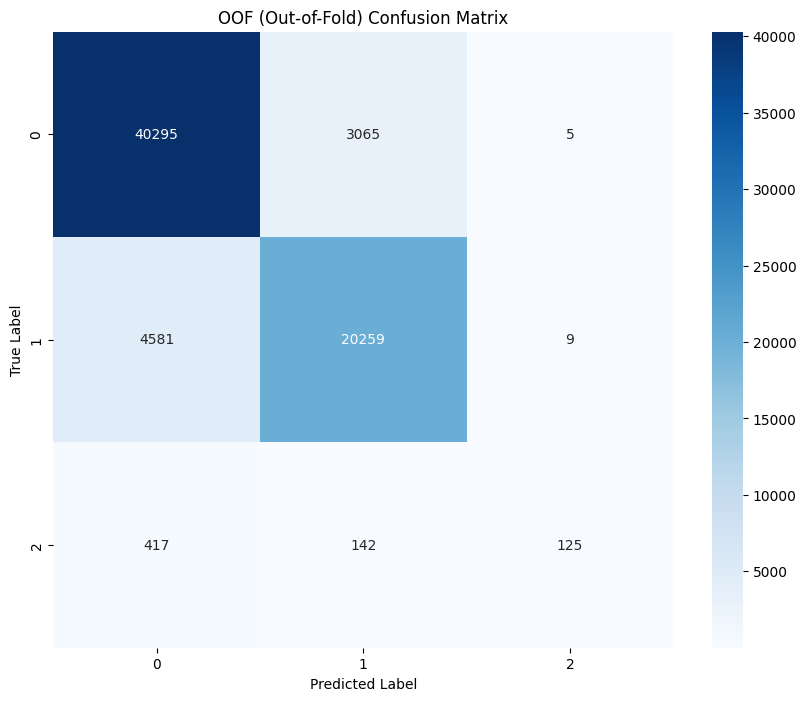

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


# 1. Get OOF labels from OOF probabilities
oof_labels = np.argmax(oof_preds, axis=1)

# (le.classes_ is [0, 1, 2])
# We must convert it to a string list ['0', '1', '2']
target_names_str = [str(c) for c in le.classes_]

# 2. Print the classification report
print("\n OOF (Out-of-Fold) Classification Report ")
print(classification_report(y_train_full, oof_labels, target_names=target_names_str))

# 3. Calculate and plot the confusion matrix
cm = confusion_matrix(y_train_full, oof_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_str, yticklabels=target_names_str) # (!! Also use it here)
plt.title('OOF (Out-of-Fold) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("oof_confusion_matrix.png") # Save the image
print("\nOOF Confusion Matrix has been saved to 'oof_confusion_matrix.png'")
plt.show()


LGBM Average Feature Importance plot has been saved to 'lgbm_feature_importance.png'


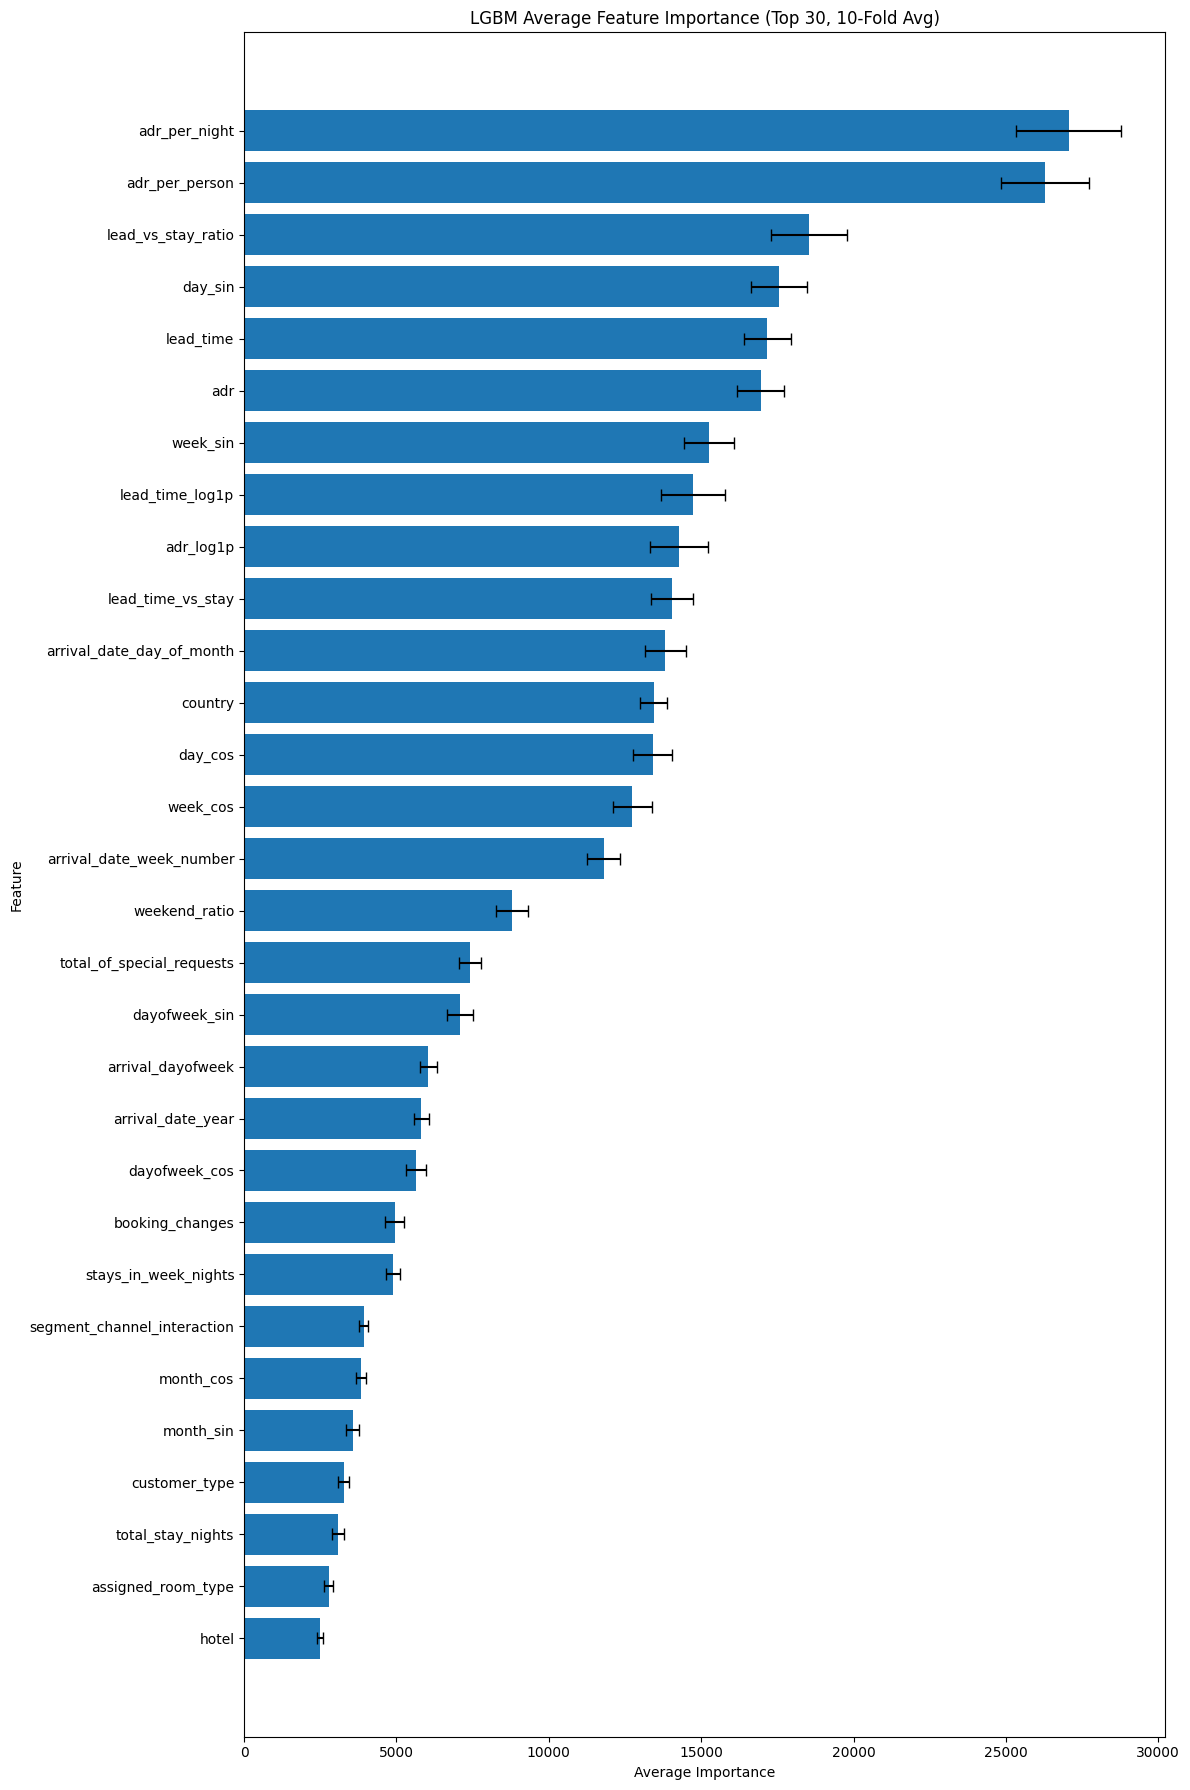

In [ ]:
# 1. Collect feature importances from all 10 folds
importances = pd.DataFrame()
importances['feature'] = X_train_final.columns

for fold_num, model in enumerate(models):
    importances[f'fold_{fold_num+1}'] = model.feature_importances_

# 2. Calculate the average and standard deviation
importances['average'] = importances.iloc[:, 1:].mean(axis=1)
importances['std'] = importances.iloc[:, 1:].std(axis=1)

# 3. Sort by average importance and get the Top 30
top_30_features = importances.sort_values(by='average', ascending=False).head(30)

plt.figure(figsize=(12, 18))
plt.title('LGBM Average Feature Importance (Top 30, 10-Fold Avg)')

# matplotlib plots from bottom-to-top, so we reverse the DataFrame
# (using [::-1]) to show the most important feature at the top.
plt.barh(
    top_30_features['feature'][::-1],         # y-axis (features, reversed)
    top_30_features['average'][::-1],         # x-axis (the bars, reversed)
    xerr=top_30_features['std'][::-1],        # error bars (reversed)
    capsize=4                                 # Add caps to error bars
)

plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.tight_layout() # Adjust layout
plt.savefig("lgbm_feature_importance.png")
print("\nLGBM Average Feature Importance plot has been saved to 'lgbm_feature_importance.png'")
plt.show()

Shortest early stopping rounds among all folds: 1368 rounds

LGBM Average Learning Curve plot has been saved to 'lgbm_learning_curve.png'


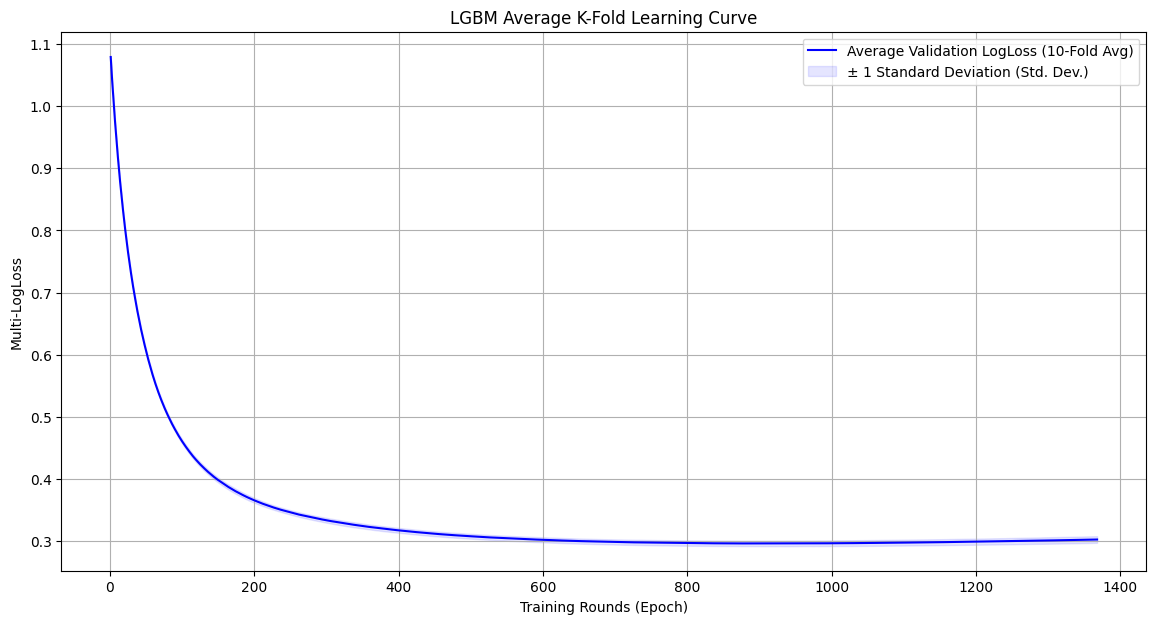

In [ ]:

# 1. Extract 'multi_logloss' from all folds
loss_histories = []
for history in fold_histories:
    # The path is: 'valid' (eval_names) -> 'multi_logloss' (eval_metric)
    loss_histories.append(history['valid']['multi_logloss'])

# 2. Find the shortest training rounds (due to early stopping)
min_epochs = min([len(h) for h in loss_histories])
print(f"Shortest early stopping rounds among all folds: {min_epochs} rounds")

# 3. Truncate all histories to the same shortest length
loss_matrix = np.array([h[:min_epochs] for h in loss_histories])

# 4. Calculate the mean and standard deviation
mean_loss = loss_matrix.mean(axis=0)
std_loss = loss_matrix.std(axis=0)
epochs = np.arange(1, min_epochs + 1)

# 5. Plot
plt.figure(figsize=(14, 7))
# Plot the average curve
plt.plot(epochs, mean_loss, label='Average Validation LogLoss (10-Fold Avg)', color='blue')

# Plot the standard deviation interval (confidence interval)
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss,
                 color='blue', alpha=0.1, label='± 1 Standard Deviation (Std. Dev.)')

plt.title('LGBM Average K-Fold Learning Curve')
plt.xlabel('Training Rounds (Epoch)')
plt.ylabel('Multi-LogLoss')
plt.legend()
plt.grid(True)
plt.savefig("lgbm_learning_curve.png")
print("\nLGBM Average Learning Curve plot has been saved to 'lgbm_learning_curve.png'")
plt.show()

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Our L1 meta model

print("Stacking Level 0: Preparation")

oof_preds_lgbm = oof_preds
test_preds_lgbm = test_preds

try:
    N_CLASSES = len(le.classes_)
except NameError:
    print("Error: LabelEncoder 'le' not found.")
    print("Please make sure the previous LGBM script has been executed and 'le' is defined.")

print(f"Number of classes (N_CLASSES) = {N_CLASSES}")

# Shape validation
assert oof_preds_lgbm.shape == (len(X_train_final), N_CLASSES), "LGBM OOF shape mismatch"
assert test_preds_lgbm.shape == (len(X_test_final), N_CLASSES), "LGBM Test prediction shape mismatch"

print(f"Successfully loaded LGBM predictions: OOF shape {oof_preds_lgbm.shape}, Test shape {test_preds_lgbm.shape}")


cnt = Counter(y_train_full)
total = sum(cnt.values())
class_weight = {k: total / v for k, v in cnt.items()}
print("Class weights:", class_weight)


# CatBoost requires class weights as a list
try:
    class_weight_list = [class_weight[i] for i in range(N_CLASSES)]
    print("Successfully created class_weight_list for CatBoost")
except NameError:
    print("Error: class_weight dictionary not found.")

# KFold object check
try:
    print(f"Using N_SPLITS = {N_SPLITS}")
except NameError:
    print("Error: 'N_SPLITS' not found.")


--- Stacking Level 0: 准备工作 ---
类别数量 (N_CLASSES) = 3
成功加载 LGBM 预测: OOF shape (68898, 3), Test shape (50000, 3)
Class weights: {np.int64(2): 100.7280701754386, np.int64(1): 2.7726669081250757, np.int64(0): 1.5887928052576963}
成功创建 CatBoost 的 class_weight_list
将使用 N_SPLITS = 10


In [ ]:

print("\n Stacking Level 0: Training CatBoost (K-Fold, OneVsAll) ")

oof_preds_cat = np.zeros((len(X_train_final), N_CLASSES))
test_preds_cat = np.zeros((len(X_test_final), N_CLASSES))


cat_models = []
cat_fold_histories = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_final, y_train_full), 1):
    print(f"\n===== CatBoost Fold {fold}/{N_SPLITS} =====")
    X_tr, X_val = X_train_final.iloc[tr_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_full[tr_idx], y_train_full[val_idx]

    model_cat = CatBoostClassifier(
        
        # 1. Switch to OneVsAll for extreme imbalance
        loss_function='MultiClassOneVsAll',
        classes_count=N_CLASSES,

        #  Performance (GPU) 
        task_type="GPU",
        iterations=20000,

        # 2. Evaluate F1
        eval_metric='TotalF1:average=Weighted',

        # 3. Shallower depth
        depth=6,

        # 4. Matching learning rate
        learning_rate=0.015,

        # 5. More patience
        early_stopping_rounds=1000,

        verbose=1000,

        
        l2_leaf_reg=3.0,
        random_strength=1.0,
        bootstrap_type='Bayesian',

        cat_features=cat_cols,

        random_seed=42 + fold
    )

    model_cat.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        cat_features=cat_cols
    )

    
    cat_models.append(model_cat)
    
    cat_fold_histories.append(model_cat.get_evals_result())

    oof_preds_cat[val_idx] = model_cat.predict_proba(X_val)
    test_preds_cat += model_cat.predict_proba(X_test_final) / N_SPLITS

print("\n CatBoost K-Fold Training Complete ")
print(f"Captured {len(cat_models)} models and {len(cat_fold_histories)} histories.")


--- Stacking Level 0: Training CatBoost (K-Fold, OneVsAll) ---

===== CatBoost Fold 1/10 =====
0:	learn: 0.7980235	test: 0.7984319	best: 0.7984319 (0)	total: 179ms	remaining: 59m 41s
1000:	learn: 0.8571017	test: 0.8554573	best: 0.8557208 (982)	total: 14.5s	remaining: 4m 34s
2000:	learn: 0.8667000	test: 0.8605554	best: 0.8607083 (1995)	total: 25.4s	remaining: 3m 48s
3000:	learn: 0.8725261	test: 0.8646997	best: 0.8646997 (2998)	total: 36.6s	remaining: 3m 27s
4000:	learn: 0.8775671	test: 0.8676727	best: 0.8676727 (3999)	total: 47.9s	remaining: 3m 11s
5000:	learn: 0.8819892	test: 0.8676599	best: 0.8682567 (4463)	total: 59s	remaining: 2m 57s
6000:	learn: 0.8866226	test: 0.8685727	best: 0.8691441 (5948)	total: 1m 10s	remaining: 2m 43s
bestTest = 0.8691440921
bestIteration = 5948
Shrink model to first 5949 iterations.

===== CatBoost Fold 2/10 =====
0:	learn: 0.7320545	test: 0.7338367	best: 0.7338367 (0)	total: 14.3ms	remaining: 4m 45s
1000:	learn: 0.8575286	test: 0.8544131	best: 0.8551487 (


--- CatBoost OOF (Out-of-Fold) Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     43365
           1       0.86      0.80      0.83     24849
           2       0.89      0.10      0.17       684

    accuracy                           0.87     68898
   macro avg       0.88      0.61      0.64     68898
weighted avg       0.87      0.87      0.87     68898


CatBoost OOF Confusion Matrix has been saved to 'catboost_oof_confusion_matrix.png'


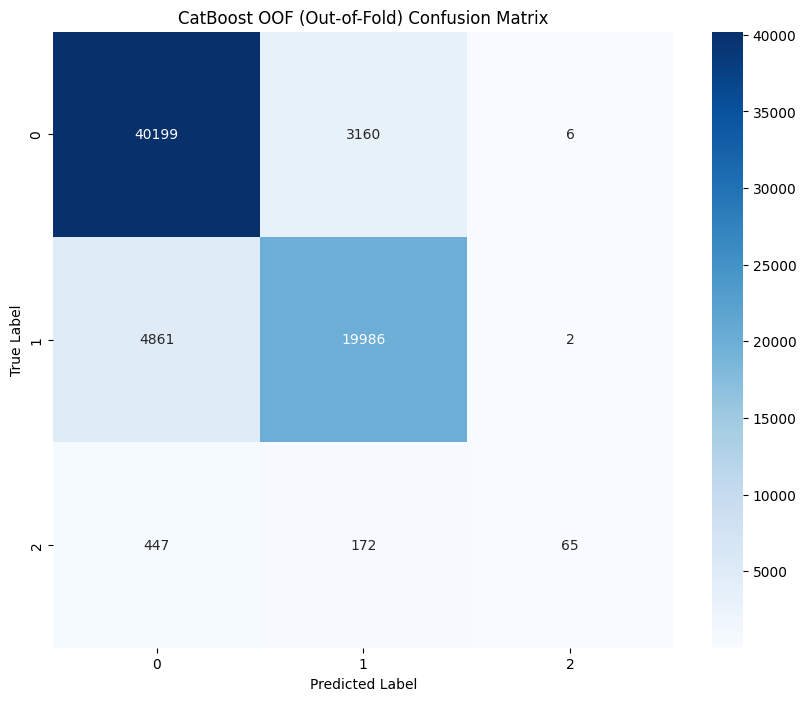

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np



# 1. Get OOF labels from OOF probabilities
oof_labels_cat = np.argmax(oof_preds_cat, axis=1)

# (le.classes_ is [0, 1, 2])
# We must convert it to a string list ['0', '1', '2']
target_names_str = [str(c) for c in le.classes_]

# 2. Print the classification report
print("\n CatBoost OOF (Out-of-Fold) Classification Report ")
print(classification_report(y_train_full, oof_labels_cat, target_names=target_names_str))

# 3. Calculate and plot the confusion matrix
cm_cat = confusion_matrix(y_train_full, oof_labels_cat)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_str, yticklabels=target_names_str)
plt.title('CatBoost OOF (Out-of-Fold) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("catboost_oof_confusion_matrix.png") # Save the image
print("\nCatBoost OOF Confusion Matrix has been saved to 'catboost_oof_confusion_matrix.png'")
plt.show()


CatBoost Average Feature Importance plot has been saved to 'catboost_feature_importance.png'


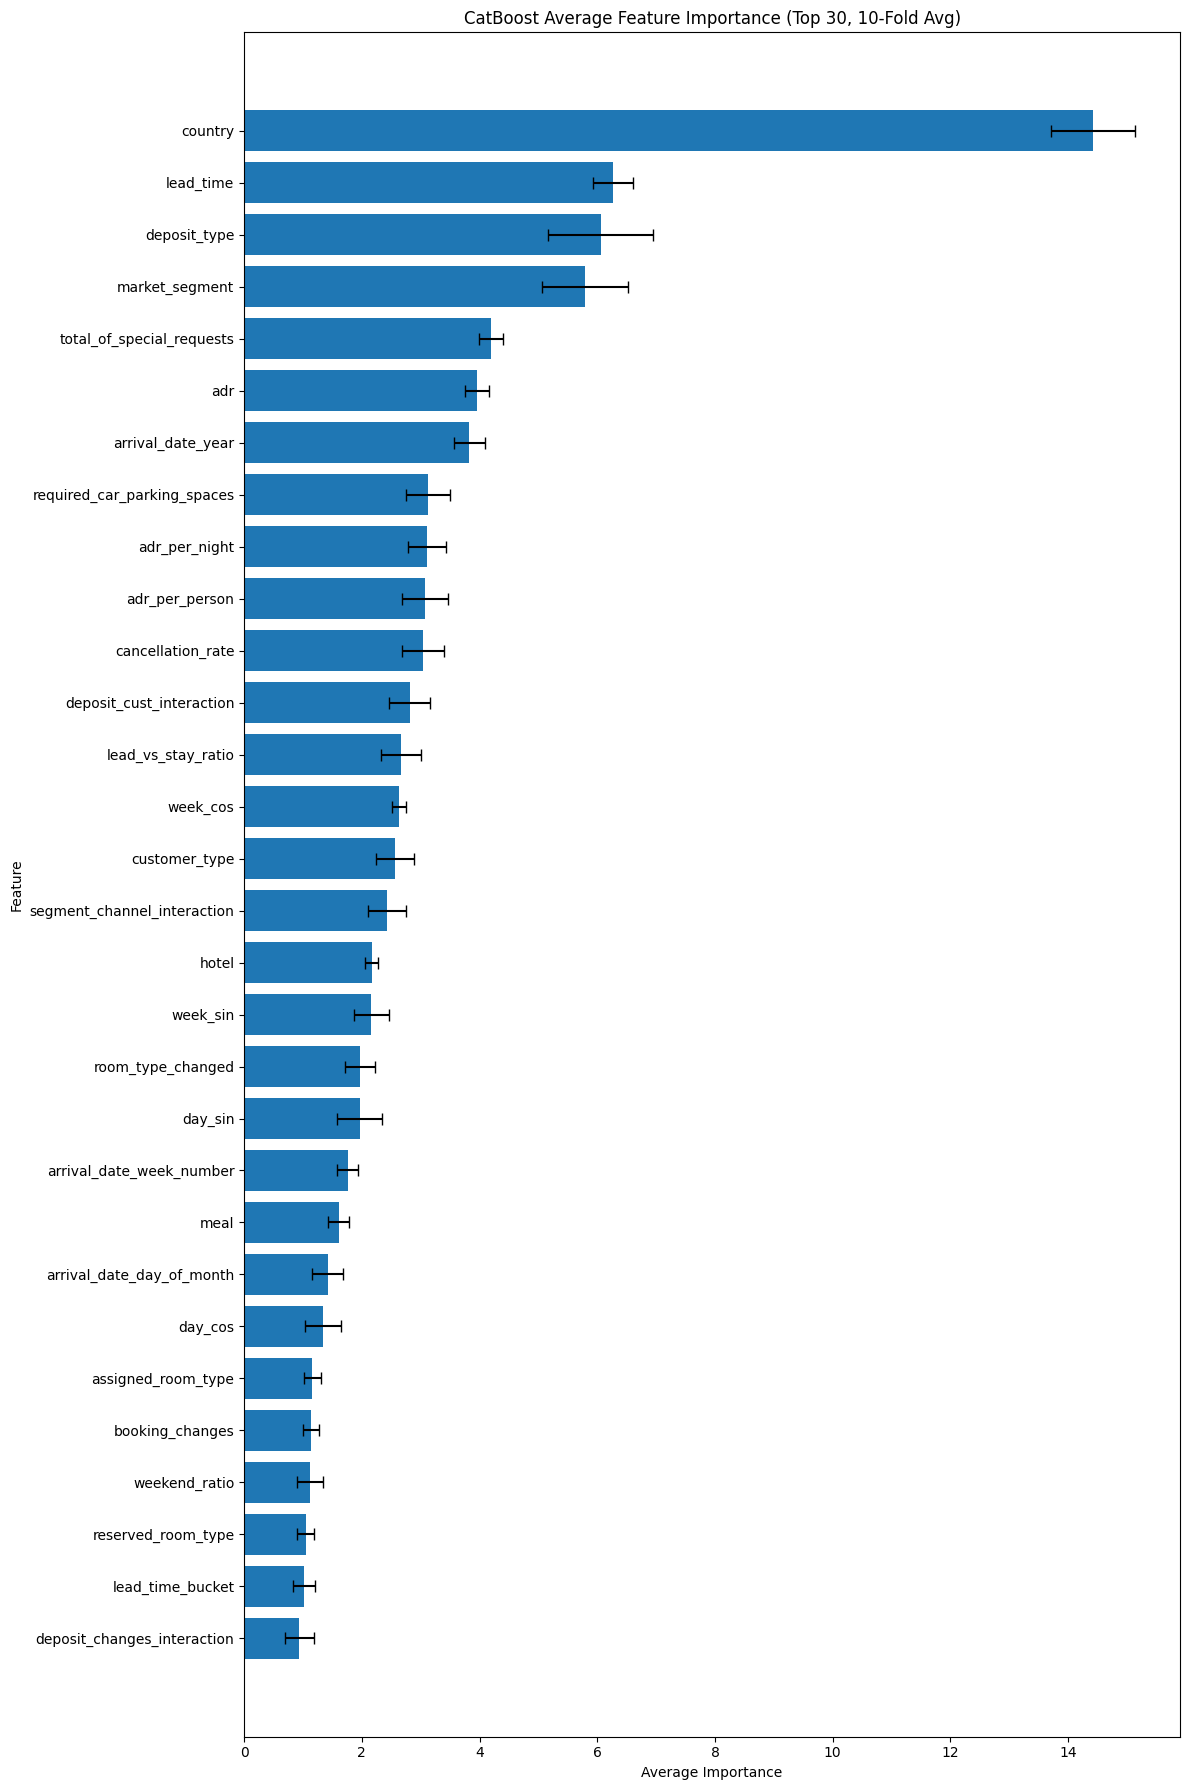

In [ ]:

# 1. Collect feature importances from all 10 folds
importances_cat = pd.DataFrame()
importances_cat['feature'] = X_train_final.columns

for fold_num, model in enumerate(cat_models):
    
    importances_cat[f'fold_{fold_num+1}'] = model.get_feature_importance()

# 2. Calculate the average and standard deviation
importances_cat['average'] = importances_cat.iloc[:, 1:].mean(axis=1)
importances_cat['std'] = importances_cat.iloc[:, 1:].std(axis=1)

# 3. Sort by average importance and get the Top 30
top_30_features_cat = importances_cat.sort_values(by='average', ascending=False).head(30)

# 4. Plot using plt.barh() (the fix for seaborn)
plt.figure(figsize=(12, 18))
plt.title('CatBoost Average Feature Importance (Top 30, 10-Fold Avg)')

# Reverse the DataFrame (using [::-1]) to show the most important feature at the top
plt.barh(
    top_30_features_cat['feature'][::-1],
    top_30_features_cat['average'][::-1],
    xerr=top_30_features_cat['std'][::-1],
    capsize=4
)

plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.tight_layout() # Adjust layout
plt.savefig("catboost_feature_importance.png")
print("\nCatBoost Average Feature Importance plot has been saved to 'catboost_feature_importance.png'")
plt.show()

Shortest early stopping rounds among all folds: 5843 rounds

CatBoost Average Learning Curve plot has been saved to 'catboost_learning_curve.png'


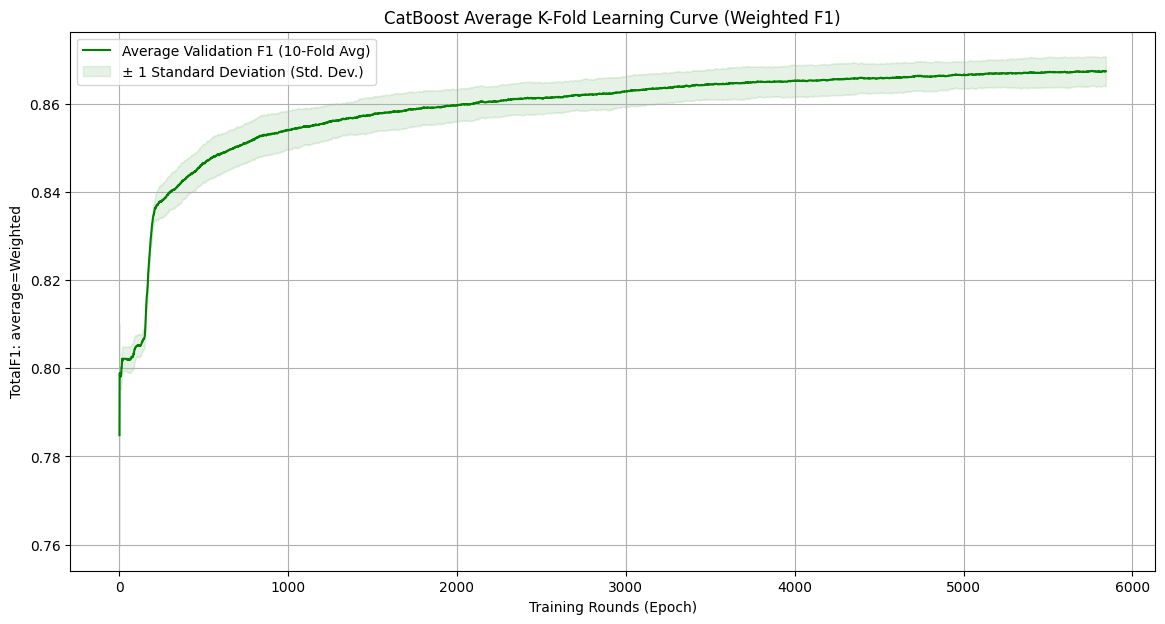

In [ ]:

# 1. Extract 'TotalF1:average=Weighted' from all folds
f1_histories = []
for history in cat_fold_histories:
    
    f1_histories.append(history['validation']['TotalF1:average=Weighted'])

# 2. Find the shortest training rounds (due to early stopping)
min_epochs = min([len(h) for h in f1_histories])
print(f"Shortest early stopping rounds among all folds: {min_epochs} rounds")

# 3. Truncate all histories to the same shortest length
f1_matrix = np.array([h[:min_epochs] for h in f1_histories])

# 4. Calculate the mean and standard deviation
mean_f1 = f1_matrix.mean(axis=0)
std_f1 = f1_matrix.std(axis=0)
epochs = np.arange(1, min_epochs + 1)

# 5. Plot
plt.figure(figsize=(14, 7))
# Plot the average curve
plt.plot(epochs, mean_f1, label='Average Validation F1 (10-Fold Avg)', color='green')

# Plot the standard deviation interval (confidence interval)
plt.fill_between(epochs, mean_f1 - std_f1, mean_f1 + std_f1,
                 color='green', alpha=0.1, label='± 1 Standard Deviation (Std. Dev.)')

plt.title('CatBoost Average K-Fold Learning Curve (Weighted F1)')
plt.xlabel('Training Rounds (Epoch)')
plt.ylabel('TotalF1: average=Weighted')
plt.legend()
plt.grid(True)
plt.savefig("catboost_learning_curve.png")
print("\nCatBoost Average Learning Curve plot has been saved to 'catboost_learning_curve.png'")
plt.show()

In [ ]:

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight # (Needed for some models, good to have)
from tqdm.notebook import tqdm 

print("\n Stacking Level 0: Training RandomForest (K-Fold) ")

print("... Filling NaNs for RF (using -999)...")
X_train_rf = X_train_final.fillna(-999)
X_test_rf  = X_test_final.fillna(-999)

# Initialize OOF and Test prediction arrays
oof_preds_rf = np.zeros((len(X_train_final), N_CLASSES))
test_preds_rf = np.zeros((len(X_test_final), N_CLASSES))

rf_models = []

kfold_iterator = list(skf.split(X_train_rf, y_train_full))

for fold, (tr_idx, val_idx) in enumerate(tqdm(kfold_iterator, desc="RF Folds"), 1):


    X_tr_rf, X_val_rf = X_train_rf.iloc[tr_idx], X_train_rf.iloc[val_idx]
    y_tr, y_val = y_train_full[tr_idx], y_train_full[val_idx]

    model_rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42 + fold,
        n_jobs=-1,
        max_depth=15,
        min_samples_leaf=5,
        verbose=0           
    )

    model_rf.fit(X_tr_rf, y_tr)

    
    rf_models.append(model_rf)

    oof_preds_rf[val_idx] = model_rf.predict_proba(X_val_rf)
    test_preds_rf += model_rf.predict_proba(X_test_rf) / N_SPLITS

print("\n RandomForest K-Fold Training Complete ")
print(f"Captured {len(rf_models)} models.")


--- Stacking Level 0: Training RandomForest (K-Fold) ---
... Filling NaNs for RF (using -999)...


RF Folds:   0%|          | 0/10 [00:00<?, ?it/s]


--- RandomForest K-Fold Training Complete ---
Captured 10 models.



--- RandomForest OOF (Out-of-Fold) Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     43365
           1       0.81      0.82      0.81     24849
           2       0.40      0.30      0.34       684

    accuracy                           0.86     68898
   macro avg       0.70      0.67      0.68     68898
weighted avg       0.86      0.86      0.86     68898


RandomForest OOF Confusion Matrix has been saved to 'rf_oof_confusion_matrix.png'


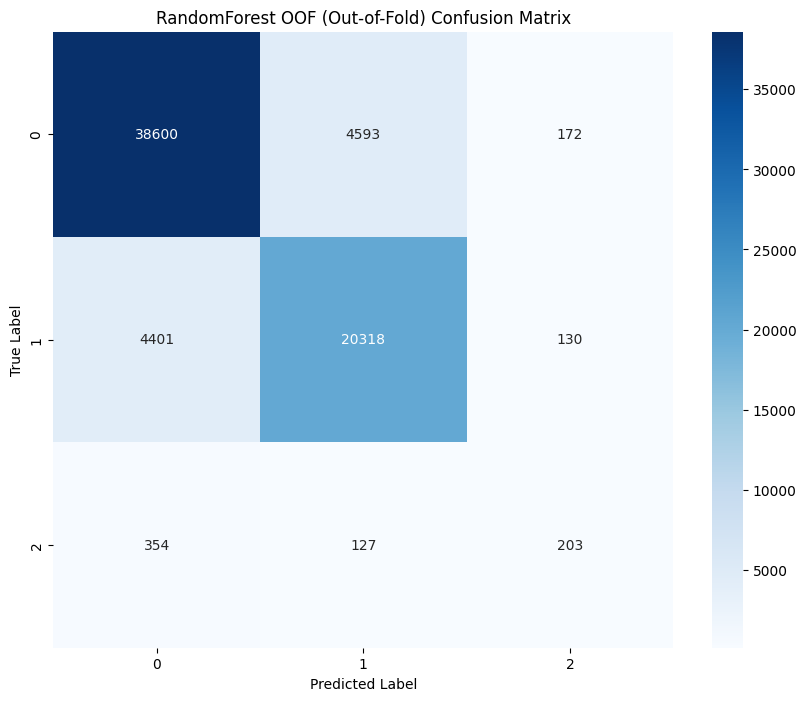

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Get OOF labels from OOF probabilities
oof_labels_rf = np.argmax(oof_preds_rf, axis=1)

# (le.classes_ is [0, 1, 2]) -> ['0', '1', '2']
target_names_str = [str(c) for c in le.classes_]

# 2. Print the classification report
print("\n RandomForest OOF (Out-of-Fold) Classification Report ")
print(classification_report(y_train_full, oof_labels_rf, target_names=target_names_str))

# 3. Calculate and plot the confusion matrix
cm_rf = confusion_matrix(y_train_full, oof_labels_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_str, yticklabels=target_names_str)
plt.title('RandomForest OOF (Out-of-Fold) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("rf_oof_confusion_matrix.png") # Save the image
print("\nRandomForest OOF Confusion Matrix has been saved to 'rf_oof_confusion_matrix.png'")
plt.show()


RandomForest Average Feature Importance plot has been saved to 'rf_feature_importance.png'


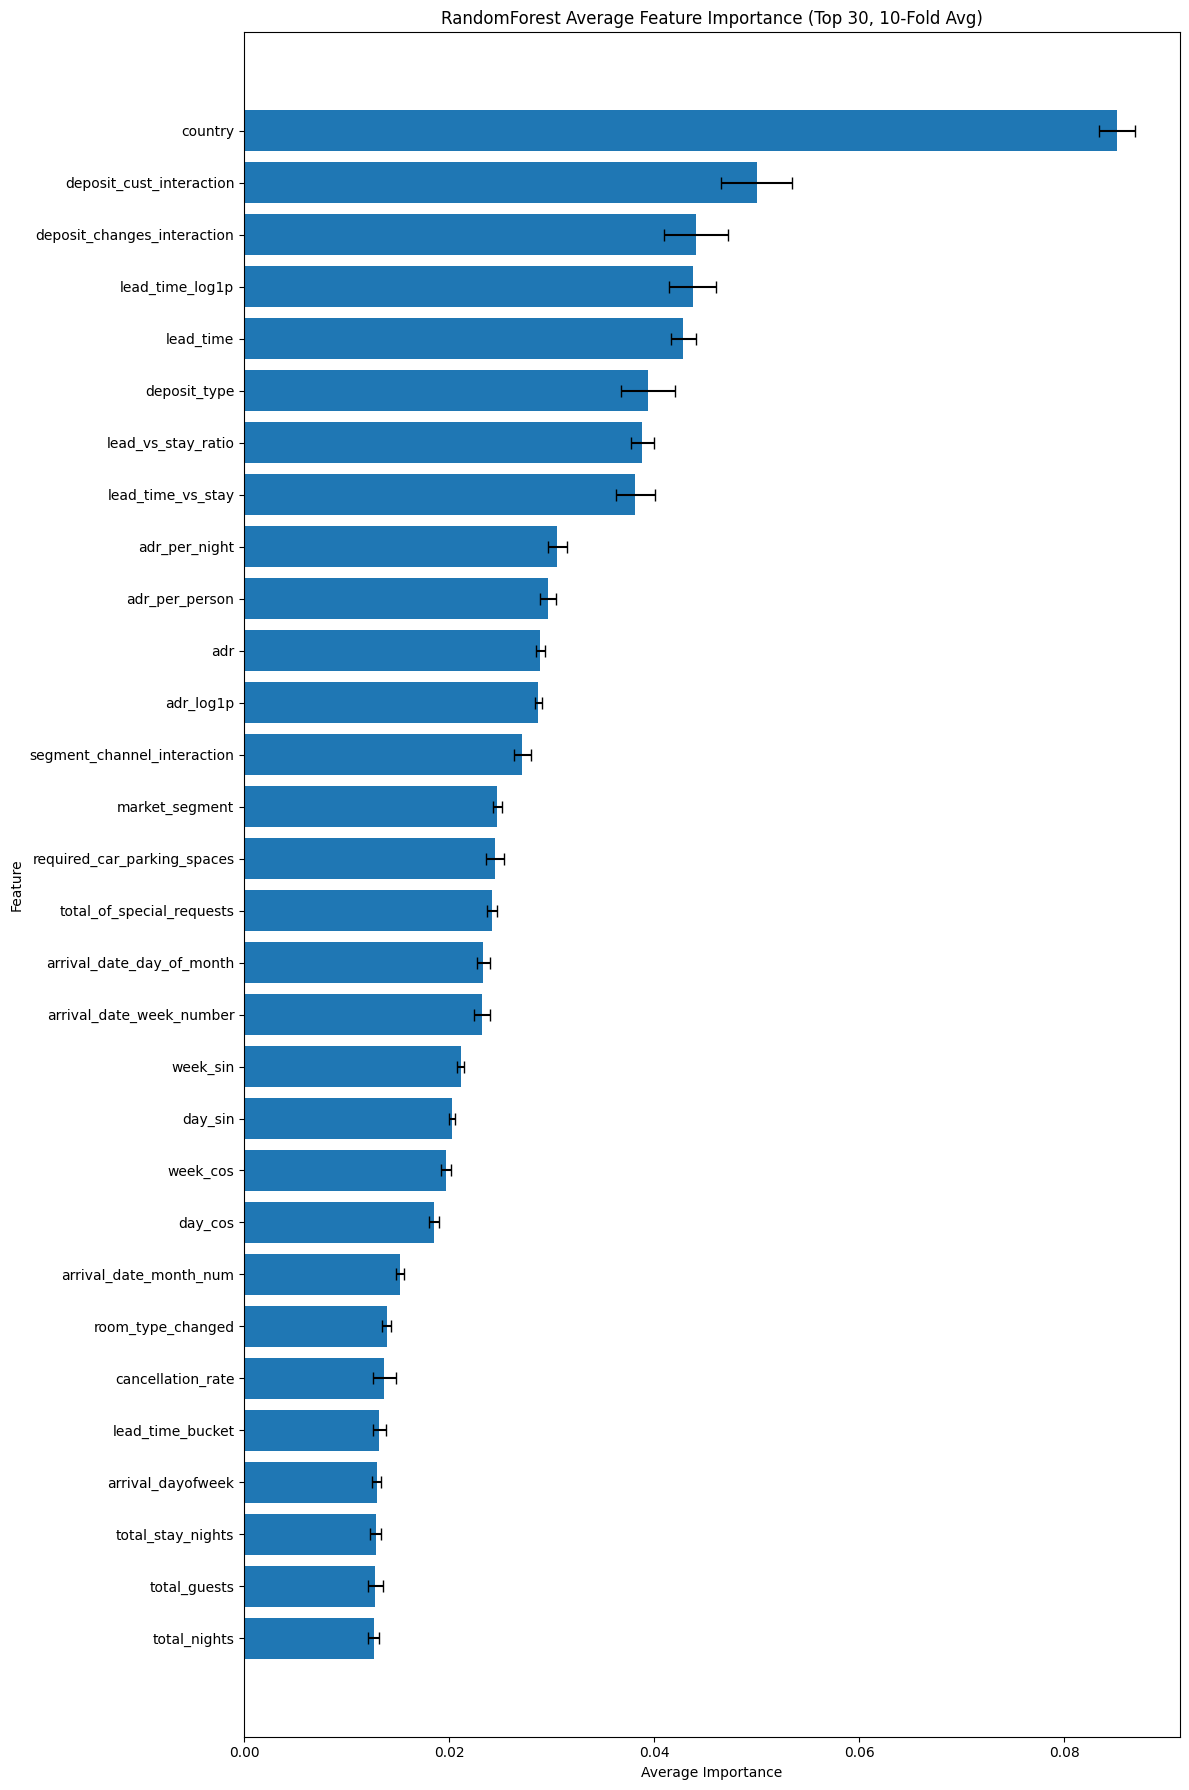

In [ ]:

# 1. Collect feature importances from all 10 folds
importances_rf = pd.DataFrame()
importances_rf['feature'] = X_train_final.columns

for fold_num, model in enumerate(rf_models):
    importances_rf[f'fold_{fold_num+1}'] = model.feature_importances_

# 2. Calculate the average and standard deviation
importances_rf['average'] = importances_rf.iloc[:, 1:].mean(axis=1)
importances_rf['std'] = importances_rf.iloc[:, 1:].std(axis=1)

# 3. Sort by average importance and get the Top 30
top_30_features_rf = importances_rf.sort_values(by='average', ascending=False).head(30)

# 4. Plot using plt.barh() (the fix for seaborn)
plt.figure(figsize=(12, 18))
plt.title('RandomForest Average Feature Importance (Top 30, 10-Fold Avg)')

# Reverse the DataFrame (using [::-1]) to show the most important feature at the top
plt.barh(
    top_30_features_rf['feature'][::-1],
    top_30_features_rf['average'][::-1],
    xerr=top_30_features_rf['std'][::-1],
    capsize=4
)

plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.tight_layout() 
plt.savefig("rf_feature_importance.png")
print("\nRandomForest Average Feature Importance plot has been saved to 'rf_feature_importance.png'")
plt.show()

In [ ]:
# (L0 Model #4) Train Keras NN (K-Fold, GPU)
# (This REPLACES RF or AdaBoost)

import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print("\n Stacking Level 0: Training Keras NN (K-Fold, GPU) ")

# 1. Initialize result arrays
oof_preds_nn = np.zeros((len(X_train_final), N_CLASSES))
test_preds_nn = np.zeros((len(X_test_final), N_CLASSES))

# 2. Define Feature Types (for preprocessor)
numeric_features = [col for col in X_train_final.columns if col not in cat_cols]
categorical_features = cat_cols

# 3. Define the NN Builder function
def build_l0_nn_classifier(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 4. K-Fold Loop
kfold_iterator = list(skf.split(X_train_final, y_train_full))

for fold, (tr_idx, val_idx) in enumerate(tqdm(kfold_iterator, desc="L0 NN Folds"), 1):

    X_tr, X_val = X_train_final.iloc[tr_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_full[tr_idx], y_train_full[val_idx]

    y_tr_hot = to_categorical(y_tr, num_classes=N_CLASSES)
    y_val_hot = to_categorical(y_val, num_classes=N_CLASSES)

    # 5. Create Preprocessor *inside* the loop
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # <-- REMOVE THIS LINE
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    #  6. Scale/Encode the data for this fold 
    print(f"Fold {fold}: Preprocessing data...")
    X_tr_scaled = preprocessor.fit_transform(X_tr)
    X_val_scaled = preprocessor.transform(X_val)

    X_test_scaled_fold = preprocessor.transform(X_test_final)

    #  7. Build and Train the NN 
    print(f"Fold {fold}: Building and training NN...")


    if hasattr(X_tr_scaled, "toarray"):
        X_tr_scaled = X_tr_scaled.toarray()
        X_val_scaled = X_val_scaled.toarray()
        X_test_scaled_fold = X_test_scaled_fold.toarray()

    input_dim = X_tr_scaled.shape[1]

    model_nn = build_l0_nn_classifier(input_dim, N_CLASSES)

    nn_early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_nn.fit(
        X_tr_scaled, y_tr_hot,
        validation_data=(X_val_scaled, y_val_hot),
        epochs=100,
        batch_size=128,
        callbacks=[nn_early_stopping],
        verbose=0
    )

    #  8. Store OOF and Test predictions 
    oof_preds_nn[val_idx] = model_nn.predict(X_val_scaled)
    test_preds_nn += model_nn.predict(X_test_scaled_fold) / N_SPLITS

print("\n Keras NN (L0) K-Fold Training Complete ")



--- Stacking Level 0: Training Keras NN (K-Fold, GPU) ---


L0 NN Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: Preprocessing data...
Fold 1: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Fold 2: Preprocessing data...
Fold 2: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Fold 3: Preprocessing data...
Fold 3: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Fold 4: Preprocessing data...
Fold 4: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Fold 5: Preprocessing data...
Fold 5: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Fold 6: Preprocessing data...
Fold 6: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Fold 7: Preprocessing data...
Fold 7: Building and training NN...
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

In [ ]:
# 4. Check OOF F1 scores for all Level 0 models

# Convert probabilities to labels using np.argmax
oof_lgbm_labels = np.argmax(oof_preds_lgbm, axis=1)
oof_cat_labels = np.argmax(oof_preds_cat, axis=1)
oof_rf_labels = np.argmax(oof_preds_rf, axis=1)
oof_nn_labels = np.argmax(oof_preds_nn, axis=1)
# oof_xgb_labels = np.argmax(oof_preds_xgb, axis=1)
# oof_ada_labels = np.argmax(oof_preds_ada, axis=1)
# oof_lr_labels = np.argmax(oof_preds_lr, axis=1)

oof_lgbm_f1 = f1_score(y_train_full, oof_lgbm_labels, average="weighted")
oof_cat_f1 = f1_score(y_train_full, oof_cat_labels, average="weighted")
oof_rf_f1 = f1_score(y_train_full, oof_rf_labels, average="weighted")
oof_nn_f1 = f1_score(y_train_full, oof_nn_labels, average="weighted")
# oof_xgb_f1 = f1_score(y_train_full, oof_xgb_labels, average="weighted")
# oof_ada_f1 = f1_score(y_train_full, oof_ada_labels, average="weighted")
# oof_lr_f1 = f1_score(y_train_full, oof_lr_labels, average="weighted")

print(f"\n Level 0 OOF F1-Weighted Evaluation ")
print(f"LGBM     OOF F1: {oof_lgbm_f1:.6f}  (Your previous best model)")
print(f"CatBoost OOF F1: {oof_cat_f1:.6f}")
print(f"RF       OOF F1: {oof_rf_f1:.6f}")
print(f"NN       OOF F1: {oof_nn_f1:.6f}")
# print(f"XGBoost  OOF F1: {oof_xgb_f1:.6f}")
# print(f"AdaBoost OOF F1: {oof_ada_f1:.6f}")
# print(f"LR       OOF F1: {oof_lr_f1:.6f}")



--- Level 0 OOF F1-Weighted 评估 ---
LGBM     OOF F1: 0.877608  (你的历史最佳模型)
CatBoost OOF F1: 0.870400
RF       OOF F1: 0.857486
NN       OOF F1: 0.859901


In [ ]:
# 5. (L1) Train meta-model and generate final submission
print("\n Stacking Level 1: Training Meta-Model ")

# L1 training data consists of OOF predictions from L0 models
# Shape: (n_samples, 3 (LGBM) + 3 (Cat) + 3 (NN) + 3 (RF)) -> (n_samples, 12)
X_meta_train = np.concatenate([
    oof_preds_lgbm,
    oof_preds_cat,
    oof_preds_nn,
    oof_preds_rf,
    # oof_preds_xgb,
    # oof_preds_ada,
    # oof_preds_lr
], axis=1)

# L1 test data consists of test predictions from L0 models
X_meta_test = np.concatenate([
    test_preds_lgbm,
    test_preds_cat,
    test_preds_nn,
    test_preds_rf,
    # test_preds_xgb,
    # test_preds_ada,
    # test_preds_lr
], axis=1)

print(f"Meta-Model train shape: {X_meta_train.shape}")
print(f"Meta-Model test shape: {X_meta_test.shape}")



--- Stacking Level 1: 训练 Meta-Model ---
Meta-Model 训练集形状: (68898, 12)
Meta-Model 测试集形状: (50000, 12)


In [ ]:
# L1 as LGBM Meta-Model
print("\n Stacking Level 1 (Strategy B): Training LGBM Meta-Model ")

# We replace LogisticRegression with a simple LGBM
# It will learn the nonlinear relationships between the stacked probability features
meta_model_lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=N_CLASSES,
    n_estimators=300,      # L1 model does not need many trees
    max_depth=3,           # L1 model must use shallow trees (2, 3 or 4) to prevent overfitting
    learning_rate=0.05,
    colsample_bytree=1,
    #random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LGBM Meta-Model...")
meta_model_lgbm.fit(X_meta_train, y_train_full)

print("...LGBM Meta-Model training completed, generating final predictions...")

final_probs_lgbm_meta = meta_model_lgbm.predict_proba(X_meta_test)
final_labels_lgbm_meta = np.argmax(final_probs_lgbm_meta, axis=1)


final_pred_orig_lgbm_meta = le.inverse_transform(final_labels_lgbm_meta)

submission_lgbm_meta = pd.DataFrame({
    "row_id": test_row_ids,
    "reservation_status": final_pred_orig_lgbm_meta
})

submission_lgbm_meta.to_csv("submission_lgbmcbnn.csv", index=False)

print("\nLGBM-Meta Stacking prediction completed! File saved as 'submission_lgbmCB.csv' ✅✅✅")
print(submission_lgbm_meta.head())
print("\nLabel distribution in LGBM-Meta Stacking submission:")
print(submission_lgbm_meta['reservation_status'].value_counts())



--- Stacking Level 1 (策略 B): 训练 LGBM Meta-Model ---
正在训练 LGBM Meta-Model...
...LGBM Meta-Model 训练完成，生成最终预测...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅✅✅ LGBM-Meta Stacking 预测完成! 文件已保存为 'submission_lgbmCB.csv' ✅✅✅
   row_id  reservation_status
0   68898                   1
1   68899                   1
2   68900                   1
3   68901                   0
4   68902                   0

LGBM-Meta Stacking 提交文件的标签分布:
reservation_status
0    32473
1    17432
2       95
Name: count, dtype: int64


In [ ]:
print("\n Stacking Level 1 (Strategy C): Training Keras MLP Meta-Model ")

# 1. Import Keras/TensorFlow and necessary utilities
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical  # (!! Important !!)
from sklearn.preprocessing import StandardScaler

# 2. Scale L1 data
print("Scaling L1 Meta features (StandardScaler)...")
scaler_L1 = StandardScaler()

X_meta_train_scaled = scaler_L1.fit_transform(X_meta_train)
X_meta_test_scaled = scaler_L1.transform(X_meta_test)

print(f"Dimensions L1 (Scaled Train): {X_meta_train_scaled.shape}")
print(f"Dimensions L1 (Scaled Test): {X_meta_test_scaled.shape}")

# 3. Convert y to One-Hot encoding
y_train_one_hot = to_categorical(y_train_full, num_classes=N_CLASSES)
print(f"Dimensions L1 Target (One-Hot): {y_train_one_hot.shape}")


# 4. Build Keras MLP model
def build_l1_mlp_classifier(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: N_CLASSES units (e.g., 3)
    # Activation: 'softmax' for multi-class probability distribution
    model.add(Dense(num_classes, activation='softmax'))

    # Loss: categorical_crossentropy for softmax
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_dim = X_meta_train_scaled.shape[1]
meta_model_nn = build_l1_mlp_classifier(input_dim, N_CLASSES)

meta_model_nn.summary()

# 5. Train L1 MLP
nn_early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,
    restore_best_weights=True
)

print("Training Keras L1 Meta-Model...")
history = meta_model_nn.fit(
    X_meta_train_scaled,
    y_train_one_hot,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[nn_early_stopping],
    verbose=1
)

print("...Keras L1 Meta-Model Training Completed.")

# 6. Generate final predictions
print("Generating final predictions (NN)...")

final_probs_nn_meta = meta_model_nn.predict(X_meta_test_scaled)

final_labels_nn_meta = np.argmax(final_probs_nn_meta, axis=1)
final_pred_orig_nn_meta = le.inverse_transform(final_labels_nn_meta)

submission_nn_meta = pd.DataFrame({
    "row_id": test_row_ids,
    "reservation_status": final_pred_orig_nn_meta
})

submission_nn_meta.to_csv("last_soumission.csv", index=False)

print("\nKerasNN-Meta Stacking prediction completed! File saved as 'submission_stacking_L1_KerasNN.csv' ✅✅✅")
print(submission_nn_meta.head())
print("\nLabel distribution in KerasNN-Meta Stacking submission:")
print(submission_nn_meta['reservation_status'].value_counts())



--- Stacking Level 1 (策略 C): 训练 Keras MLP Meta-Model ---
正在缩放 L1 Meta 特征 (StandardScaler)...
Dimensions L1 (Scaled Train): (68898, 12)
Dimensions L1 (Scaled Test): (50000, 12)
Dimensions L1 Target (One-Hot): (68898, 3)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

开始训练 Keras L1 Meta-Model...
Epoch 1/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8374 - loss: 0.4136 - val_accuracy: 0.8825 - val_loss: 0.2901
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8778 - loss: 0.3088 - val_accuracy: 0.8825 - val_loss: 0.2859
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8789 - loss: 0.2988 - val_accuracy: 0.8806 - val_loss: 0.2847
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8776 - loss: 0.3019 - val_accuracy: 0.8826 - val_loss: 0.2834
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8802 - loss: 0.2980 - val_accuracy: 0.8833 - val_loss: 0.2829
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8776 - loss: 0.2940 - val_accuracy: 0.8840 - val_loss: 0.2832
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8792 - loss: 0.2983 - val_accuracy: 0.8833 - val_loss: 0.2819
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8